# On-policy vs. Off-policy (Sarsa vs. Q-learning)
<b>Gabriele Prato, McGill University</b>

In this notebook, we will be comparing Sarsa and Q-learning, an on-policy and off-policy control algorithm, on the Windy Gridworld environment described in the class textbook [1]. The goal will also be to observe how giving the agent more choice of actions affects its performance on the task.

Example 6.5, Exercices 6.7 and 6.8 will be implemented as well as the Sarsa and Q-learning algorithm.

## Libraries and Modules

In [9]:
!pip install ipythonblocks

In [10]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from ipythonblocks import BlockGrid
from IPython.display import clear_output

## Example 6.5: Windy Gridworld

For this first example, only four possible actions are allowed: up, right, down and left. More actions will be added in Exercice 6.7.

The implemented Windy Gridworld is the same as the one described in the textbook [1]. As is the case with other Gridworlds exercices, the agent cannot leave the grid. He can waste an action trying to move outside of it, but he will stay in the same state or "position" as before the action, of course receiving a negative reward of -1.

To be noted, we use the term Strong Wind when talking about the wind columns that move the agent by two tiles and Wind for columns that move the agent by one.

In [51]:
UP = np.array([1, 0])
RIGHT = np.array([0, 1])
DOWN = np.array([-1, 0])
LEFT = np.array([0, -1])
NO_MOVEMENT = np.array([0, 0]) # Used when no wind affects the agent and is a possible action in Exercice 6.7

ACTIONS = np.array([UP, RIGHT, DOWN, LEFT])

In [13]:
class WindyGridWorld:
    def __init__(self):
        self.state = [3, 0]
        self.GOAL = [3, 7]
        self.MAX_ROW = 6
        self.MAX_COLUMN = 9
        self.WIND_COLUMNS = {3, 4, 5, 8}
        self.STRONG_WIND_COLUMNS = {6, 7}
        
    def takeAction(self, action):
        self.state += action + self.getWindFactor()
        
        self.adjustStateIfOutsideGrid() # Agent is not allowed outside the grid, either by moving or pushed by wind

        if np.array_equal(self.state, self.GOAL):
            return 0
        else:
            return -1
    
    def getWindFactor(self):
        if self.state[1] in self.WIND_COLUMNS:
            return UP
        elif self.state[1] in self.STRONG_WIND_COLUMNS:
            return UP * 2
        else:
            return NO_MOVEMENT
    
    def adjustStateIfOutsideGrid(self):
        if self.state[0] < 0:
            self.state[0] = 0
        elif self.state[0] > self.MAX_ROW:
            self.state[0] = self.MAX_ROW
            
        if self.state[1] < 0:
            self.state[1] = 0
        elif self.state[1] > self.MAX_COLUMN:
            self.state[1] = self.MAX_COLUMN
    
    def reset(self):
        self.state = [3, 0]
        
    # Displays the current state of the environment in a nice colored grid
    def view(self):
        gridHeight = self.MAX_ROW
        gridWidth = self.MAX_COLUMN
        
        grid = BlockGrid(self.MAX_COLUMN + 1, self.MAX_ROW + 1, fill=(224, 224, 224))
        grid[:, 3:9] = (204, 229, 255)
        grid[:, 6:8] = (153, 229, 255)
        grid[gridHeight - self.state[0], self.state[1]] = (0, 0, 0)
        grid[gridHeight - self.GOAL[0], self.GOAL[1]] = (255, 0, 0)
        
        grid.show()

In [52]:
environment = WindyGridWorld()
environment.view()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


Initial state of the Windy Gridworld. <br />
Agent: <span style="font-size:200%">■</span> &nbsp; 
Goal: <span style="color:red;font-size: 200%">■</span> &nbsp; 
Wind: <span style="color:rgb(204, 229, 255);font-size: 200%">■</span> &nbsp; 
Strong wind: <span style="color:rgb(153, 229, 255);font-size: 200%">■</span> &nbsp; 
No wind: <span style="color:rgb(224, 224, 224);font-size: 200%">■</span>
<hr/>

The following class (ControlAlgorithm) is the base for our Sarsa and Q-learning class. ControlAlgorithm has all the code used to run the core algorithm multiple times, average the statistics and view the learned policy, while Sarsa and Qlearning only  contain the core algorithm.

In [15]:
class ControlAlgorithm:
    def __init__(self, environment, ALPHA, DISCOUNT, EPSILON):
        self.Q = np.zeros((environment.MAX_ROW + 1, environment.MAX_COLUMN + 1, ACTIONS.shape[0]))
        self.environment = environment
        self.ALPHA = ALPHA
        self.DISCOUNT = DISCOUNT
        self.EPSILON = EPSILON
      
    def averageMTimesOverNSteps(self, M, N):
        episodesPerTimeStep = np.zeros((M, N))
        for i in range(M):
            self.resetQ()
            episodesPerTimeStep[i] = self.runForNTimeSteps(N)

        return np.average(episodesPerTimeStep, axis=0)
    
    def resetQ(self):
        self.Q = np.zeros((self.environment.MAX_ROW + 1, self.environment.MAX_COLUMN + 1, ACTIONS.shape[0]))
    
    def runForNTimeSteps(self, N):
        stepCount = 0
        episodeCount = 0
        episodesPerTimeStep = np.zeros(N)
        
        while stepCount < N:
            episodeLength = self.generateEpisode()
            
            for i in range(stepCount, stepCount + episodeLength):
                if i >= N:
                    break
                
                episodesPerTimeStep[i] = episodeCount
                
            stepCount += episodeLength
            episodeCount += 1
        
        return episodesPerTimeStep
    
    def chooseAction(self):
        if np.random.rand(1)[0] <= self.EPSILON:
            actionId = np.random.randint(ACTIONS.shape[0], size=1)[0]
        else:
            actionId = np.argmax(self.Q[self.environment.state[0], self.environment.state[1]])
            
            # If multiple actions have the same max value, we need to choose one of them randomly
            possibleActions = []
            for i in range(ACTIONS.shape[0]):
                if (self.Q[self.environment.state[0], self.environment.state[1], i] == 
                   self.Q[self.environment.state[0], self.environment.state[1], actionId]):
                    possibleActions.append(i)
                    
            actionId = random.choice(possibleActions)
        
        return ACTIONS[actionId], actionId
    
    def chooseGreedyAction(self):
        actionId = np.argmax(self.Q[self.environment.state[0], self.environment.state[1]])

        # If multiple actions have the same max value, we need to choose one of them randomly
        possibleActions = []
        for i in range(ACTIONS.shape[0]):
            if (self.Q[self.environment.state[0], self.environment.state[1], i] == 
               self.Q[self.environment.state[0], self.environment.state[1], actionId]):
                possibleActions.append(i)

        actionId = random.choice(possibleActions)

        return ACTIONS[actionId], actionId
    
    # Displays the learned policy trying to complete an episode.
    # The greedy policy is used and thus the episode might not finish if the learned policy is not trained enough.
    def viewLearnedPolicy(self):
        self.environment.reset()
        self.environment.view()
        
        reward = -1
        
        while reward == -1:
            previousState = np.copy(self.environment.state)
            
            action, actionId = self.chooseGreedyAction()
            reward = self.environment.takeAction(action)
            
            clear_output()
            self.environment.view()
            time.sleep(0.5)

In [16]:
class Sarsa(ControlAlgorithm):
    def __init__(self, environment, ALPHA, DISCOUNT, EPSILON):
        ControlAlgorithm.__init__(self, environment, ALPHA, DISCOUNT, EPSILON)
        
    def generateEpisode(self):
        self.environment.reset()
        
        stepCount = 0
        reward = -1

        action, actionId = self.chooseAction()
        
        while reward == -1:
            previousState = np.copy(self.environment.state)
            reward = self.environment.takeAction(action)
        
            nextAction, nextActionId = self.chooseAction()
        
            self.Q[previousState[0], previousState[1], actionId] += self.ALPHA * (reward + 
                self.DISCOUNT * self.Q[self.environment.state[0], self.environment.state[1], nextActionId] - 
                self.Q[previousState[0], previousState[1], actionId])
            
            action = nextAction
            actionId = nextActionId
            stepCount += 1
        
        return stepCount

In [17]:
class Qlearning(ControlAlgorithm):
    def __init__(self, environment, ALPHA, DISCOUNT, EPSILON):
        ControlAlgorithm.__init__(self, environment, ALPHA, DISCOUNT, EPSILON)
        
    def generateEpisode(self):
        self.environment.reset()
        
        stepCount = 0
        reward = -1

        while reward == -1:
            previousState = np.copy(self.environment.state)
            
            action, actionId = self.chooseAction()
            reward = self.environment.takeAction(action)
        
            self.Q[previousState[0], previousState[1], actionId] += self.ALPHA * (reward + 
                self.DISCOUNT * np.max(self.Q[self.environment.state[0], self.environment.state[1]]) - 
                self.Q[previousState[0], previousState[1], actionId])
            
            stepCount += 1
        
        return stepCount

The α (ALPHA), γ (DISCOUNT) and ε (EPSILON) values used are the same as in the book, though different epsilon values will be compared later on.

In [53]:
ALPHA = 0.5
DISCOUNT = 1.0
EPSILON = 0.1
s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

Let's view the learned policy after 1000 time steps of training. The greedy policy will be used as we want to test if the optimal policy was learned.<br />
*** If the agent gets stuck in a loop, feel free to stop the kernel. ***

In [54]:
s.runForNTimeSteps(1000)
s.viewLearnedPolicy()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


KeyboardInterrupt: 

Of course, 1000 steps is not enough to learn the optimal policy and the agent gets stuck in a loop. Let's try with 100000 time steps of training.<br />
*** Again, feel free to stop the kernel if the agent gets stuck. ***

In [55]:
s.runForNTimeSteps(100000)
s.viewLearnedPolicy()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


Results will vary due to randomness, but usually after 100000 time steps, the learned policy is optimal and finishes the episode.<br />

We can try the same experiment with the Q-learning algorithm:

In [56]:
ql.runForNTimeSteps(100000)
ql.viewLearnedPolicy()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


Results seem to be the same as with Sarsa, they both learn the optimal policy. <br />

Now lets verify which algorithm learns the optimal policy the fastest:

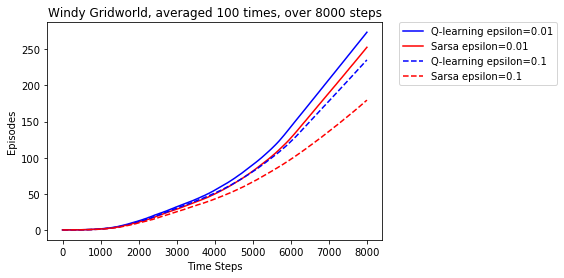

In [24]:
EPSILON = 0.01

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

episodesPerTimeStepSarsa1 = s.averageMTimesOverNSteps(100, 8000)
episodesPerTimeStepQlearning1 = ql.averageMTimesOverNSteps(100, 8000)

EPSILON = 0.1

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

episodesPerTimeStepSarsa2 = s.averageMTimesOverNSteps(100, 8000)
episodesPerTimeStepQlearning2 = ql.averageMTimesOverNSteps(100, 8000)

plt.plot(np.arange(1, 8001), episodesPerTimeStepQlearning1, 'b', label="Q-learning epsilon=0.01")
plt.plot(np.arange(1, 8001), episodesPerTimeStepSarsa1, 'r', label="Sarsa epsilon=0.01")
plt.plot(np.arange(1, 8001), episodesPerTimeStepQlearning2, 'b--', label="Q-learning epsilon=0.1")
plt.plot(np.arange(1, 8001), episodesPerTimeStepSarsa2, 'r--', label="Sarsa epsilon=0.1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time Steps')
plt.ylabel('Episodes')
plt.title('Windy Gridworld, averaged 100 times, over 8000 steps')
plt.show()

Here we compare two ε values for each algorithm. ε = 0.1 is the value used in the book. We added ε = 0.01 to compare performance. <br />

As we can see, for the same epsilon value, Q-learning performs better than Sarsa on the Windy Gridworld. It learns the optimal policy quicker than Sarsa. <br />

Also, ε = 0.01 gives better results, as is expected. ε = 0.1 doesn't seem to give any major advantage in the early phase of learning, as could of been the case. Maybe a higher ε value would make a difference, but then again, in the early phase, the greedy actions are not set in stone yet as the optimal policy is far from learned.

## Exercice 6.7: Windy Gridworld with King's Moves
In this exercice, we add more actions that can be chosen by the agent and test how this affects the results.

### Eight possible actions

In [25]:
UP_LEFT = np.array([1, -1])
UP_RIGHT = np.array([1, 1])
DOWN_RIGHT = np.array([-1, 1])
DOWN_LEFT = np.array([-1, -1])
ACTIONS = np.array([UP, RIGHT, DOWN, LEFT, UP_LEFT, UP_RIGHT, DOWN_RIGHT, DOWN_LEFT])

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

In [30]:
s.runForNTimeSteps(100000)
s.viewLearnedPolicy()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


The learned policy is different than the with only the four basic actions, since the agent can counter the wind by moving down and right at the same time.

In [29]:
ql.runForNTimeSteps(100000)
ql.viewLearnedPolicy()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


The policy learned by Q-learning is of course very similar (randomness impacting resulsts) as with Sarsa, the exception being that Q-learning in Example 6.5 learned the optimal policy quicker. Let's have a look now to see how things changed:

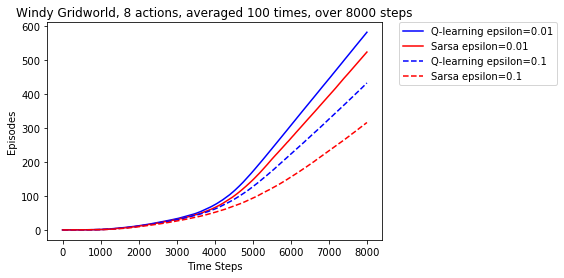

In [31]:
EPSILON = 0.01

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

episodesPerTimeStepSarsa1 = s.averageMTimesOverNSteps(100, 8000)
episodesPerTimeStepQlearning1 = ql.averageMTimesOverNSteps(100, 8000)

EPSILON = 0.1

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

episodesPerTimeStepSarsa2 = s.averageMTimesOverNSteps(100, 8000)
episodesPerTimeStepQlearning2 = ql.averageMTimesOverNSteps(100, 8000)

plt.plot(np.arange(1, 8001), episodesPerTimeStepQlearning1, 'b', label="Q-learning epsilon=0.01")
plt.plot(np.arange(1, 8001), episodesPerTimeStepSarsa1, 'r', label="Sarsa epsilon=0.01")
plt.plot(np.arange(1, 8001), episodesPerTimeStepQlearning2, 'b--', label="Q-learning epsilon=0.1")
plt.plot(np.arange(1, 8001), episodesPerTimeStepSarsa2, 'r--', label="Sarsa epsilon=0.1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time Steps')
plt.ylabel('Episodes')
plt.title('Windy Gridworld, 8 actions, averaged 100 times, over 8000 steps')
plt.show()

As we've seen, Sarsa and Q-learning find a quicker route thanks to the four new actions. It shows in the graph, as the number of episodes terminated within 8000 time steps has more than doubled.<br />

Again, Q-learning performs better than Sarsa by learning the optimal policy quicker.<br />

ε = 0.01 is again better, as expected, though to a greater extent it seems than with only four possible actions. This makes sense since learning the optimal policy with a higher ε takes longer and when choosing a non greedy action, the chance of picking the optimal one is now lower since there are more possible actions.<br/>

Let's see if adding a ninth action helps.

### Nine possible actions
Here we add the NO_MOVEMENT action, where the agent just wastes one action and does nothing. Note that the wind still affects the agent even when he decides not to move.

In [33]:
ACTIONS = np.array([UP, RIGHT, DOWN, LEFT, UP_LEFT, UP_RIGHT, DOWN_RIGHT, DOWN_LEFT, NO_MOVEMENT])

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

In [35]:
s.runForNTimeSteps(100000)
s.viewLearnedPolicy()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


The learned policy seems to be the same on average (randomness affects results). This is expected, as not moving does not help in this case. The agent could let the wind push him to the goal by going under it, but it is still faster to also move towardsthe goal while getting pushed by the wind.

In [36]:
ql.runForNTimeSteps(100000)
ql.viewLearnedPolicy()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


Same as before, the learned policy by Q-learning is as expected on average the same as with Sarsa. The difference is how quickly they learn the optimal policy. Let us have a look:

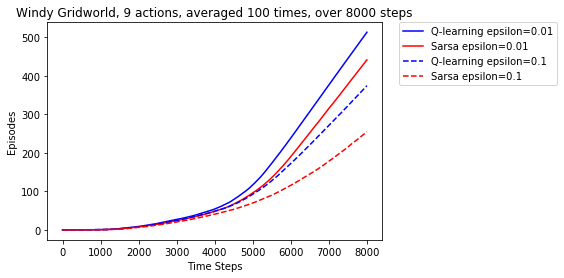

In [37]:
EPSILON = 0.01

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

episodesPerTimeStepSarsa1 = s.averageMTimesOverNSteps(100, 8000)
episodesPerTimeStepQlearning1 = ql.averageMTimesOverNSteps(100, 8000)

EPSILON = 0.1

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

episodesPerTimeStepSarsa2 = s.averageMTimesOverNSteps(100, 8000)
episodesPerTimeStepQlearning2 = ql.averageMTimesOverNSteps(100, 8000)

plt.plot(np.arange(1, 8001), episodesPerTimeStepQlearning1, 'b', label="Q-learning epsilon=0.01")
plt.plot(np.arange(1, 8001), episodesPerTimeStepSarsa1, 'r', label="Sarsa epsilon=0.01")
plt.plot(np.arange(1, 8001), episodesPerTimeStepQlearning2, 'b--', label="Q-learning epsilon=0.1")
plt.plot(np.arange(1, 8001), episodesPerTimeStepSarsa2, 'r--', label="Sarsa epsilon=0.1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time Steps')
plt.ylabel('Episodes')
plt.title('Windy Gridworld, 9 actions, averaged 100 times, over 8000 steps')
plt.show()

The number of episodes completed has diminished. With one more possible action, both algorithms take longer to learn the policy. Not moving doesn't seem to help. The algorithms need to learn that and this eats away some time steps.<br/>

Again here, Q-learning learns the optimal policy faster than Sarsa. The difference between the number of episodes completed is very similar to the 8 actions problem. The algorithms taking a bit longer to learn the optimal policy seems to be the only impact of adding a ninth action.<br/>

ε affects the results in the same way as before.

## Exercice 6.8: Stochastic Wind

As is explained in the book, this exercice adds randomness to the wind factor. It will be interesting to see how this affects the learning algorithms.<br/>
The StochasticWindyGridWorld class is the same as the WindyGridWorld and uses it as it's basis. The class simply overrides the getWindFactor() function of the class.

In [38]:
class StochasticWindyGridWorld(WindyGridWorld):
    def __init__(self):
        WindyGridWorld.__init__(self)
    
    def getWindFactor(self):
        if self.state[1] in self.WIND_COLUMNS:
            return UP * np.random.randint(3, size=1)[0]
        elif self.state[1] in self.STRONG_WIND_COLUMNS:
            return UP * np.random.randint(3, size=1)[0] + UP
        else:
            return NO_MOVEMENT

In [46]:
environment = StochasticWindyGridWorld()
s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

In [47]:
s.runForNTimeSteps(100000)
s.viewLearnedPolicy()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


As we can see, the algorithm is way more cautious about its approach. The learned policy makes the agent go very low in the grid, in case the wind pushes it too much. This way, it can compensate for the randomness of the wind and adjust its position as it goes.<br/>

It is funny to sometines see the agent pass over the goal and needing to come back on the right, again going low in case the wind pushes it strongly. Sometimes though, it gets stuck on the right. Skipping over the goal must not happen often and so, even with 100000 time steps of practice, it hasn't always learned the optimal policy.

In [48]:
ql.runForNTimeSteps(100000)
ql.viewLearnedPolicy()

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


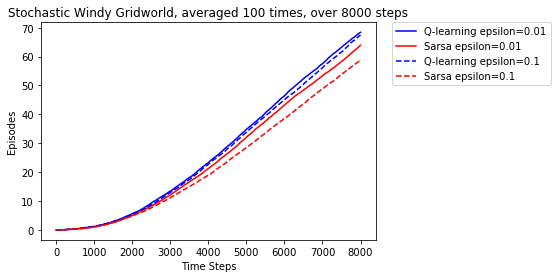

In [398]:
EPSILON = 0.01

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

episodesPerTimeStepSarsa1 = s.averageMTimesOverNSteps(100, 8000)
episodesPerTimeStepQlearning1 = ql.averageMTimesOverNSteps(100, 8000)

EPSILON = 0.1

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)

episodesPerTimeStepSarsa2 = s.averageMTimesOverNSteps(100, 8000)
episodesPerTimeStepQlearning2 = ql.averageMTimesOverNSteps(100, 8000)

plt.plot(np.arange(1, 8001), episodesPerTimeStepQlearning1, 'b', label="Q-learning epsilon=0.01")
plt.plot(np.arange(1, 8001), episodesPerTimeStepSarsa1, 'r', label="Sarsa epsilon=0.01")
plt.plot(np.arange(1, 8001), episodesPerTimeStepQlearning2, 'b--', label="Q-learning epsilon=0.1")
plt.plot(np.arange(1, 8001), episodesPerTimeStepSarsa2, 'r--', label="Sarsa epsilon=0.1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time Steps')
plt.ylabel('Episodes')
plt.title('Stochastic Windy Gridworld, averaged 100 times, over 8000 steps')
plt.show()

These results are the most interesting so far. Both Sarsa and Q-learning have very similar results, even with varying epsilons.<br/>

The number of terminated episodes is at its lowest. The algorithms have to be very cautious and adjust to the random wind, taking them more time to reach the goal. Q-learning performs better than Sarsa again, but surprisingly, even Q-learning with ε = 0.1 beats Sarsa with ε = 0.01. Q-learning results are very similar for both ε values, almost indistinguishable. Sarsa results vary more though with different ε values.<br/>

Another interesting observation is that both algorithms seem to learn the "optimal" policy very quickly. This may be explained by the fact that there is not really an optimal policy due to the randomness of the wind. A best approach to the goal is more the "optimal policy".

## Conclusion

We've implemented and compared the Sarsa and Q-learning algorithm on the Windy GridWorld environment found in the class textbook [1].<br/>

All in all, Q-learning performed better than Sarsa with equal ε (except in the schocastic wind case, Q-learning always did better even with varying ε).<br/>

It would be interesting to try and compare other on-policy and off-policy algorithms on the Windy Gridworld environment, to see if off-policy algorithms always beat on-policy algorithms.<br/>

The same could be said about trying and comparing Sarsa and Q-learning on other environments, to see if Q-learning always beats Sarsa.

## References

[1] <a href="https://webdocs.cs.ualberta.ca/~sutton/book/the-book-2nd.html">Richard S. Sutton and Andrew G. Barto, "Reinforcement learning: An introduction", Second Edition, MIT Press</a>, in preparation<br />
The Windy Gridworld example and exercices can be found on page 138-139